# Loading the data

Load the training and test data, both of the dataset is balanced. 'Class Index' column represents the classes

* 1 represents "world news"
* 2 represents "sports news"
* 3 represents "business news"
* 4 represents "science technology news"



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import html
from bs4 import BeautifulSoup

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
train_data = pd.read_csv('/content/train_subset_1000.csv')
test_data = pd.read_csv('/content/test.csv')

In [3]:
def clean_text(text):

    # Step 1) 
    # Remove all <a> tags and their content (links)
    soup = BeautifulSoup(text, "html.parser")
    for a_tag in soup.find_all('a'):
        a_tag.decompose()  # Removes the <a> tag completely

    # Extract the cleaned text
    cleaned_text = soup.get_text()

    # Step 2) 
    # Remove extra spaces and unwanted characters
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # Step 3) 
    # Remove backslashes
    cleaned_text = re.sub(r'\\', ' ', cleaned_text)

    # Step 4) 
    # Explicitly replace #39; with an apostrophe and remove space before 's
    cleaned_text = re.sub(r'#39;', "'", cleaned_text)
    cleaned_text = re.sub(r"\s+'s", "'s", cleaned_text)

    # Replace #36; with $ sign
    cleaned_text = re.sub(r'#36;', '$', cleaned_text)

    return cleaned_text

In [4]:
train_data['raw_text'] = train_data['Title'] + '. ' + train_data['Description']
train_data['labels'] = train_data['Class Index'] - 1 # did this for the distBERT model
train_data['text'] = train_data['raw_text'].apply(clean_text)
train_data.drop(['Title', 'Description', 'raw_text', 'Class Index'], inplace=True, axis=1)
train_data.head()

<ipython-input-3-a8185251c626>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,labels,text
0,0,"Explosion Rocks Baghdad Neighborhood. BAGHDAD,..."
1,0,BBC reporters' log. BBC correspondents record ...
2,0,Israel welcomes Rice nomination; Palestinians ...
3,0,Medical Journal Calls for a New Drug Watchdog....
4,0,Militants Kidnap Relatives of Iraqi Minister-T...


In [5]:
# Note that test data is balanced as well, 1900 samples from each class
test_data['raw_text'] = test_data['Title'] + '. ' + test_data['Description']
test_data['labels'] = test_data['Class Index'] - 1
test_data['text'] = test_data['raw_text'].apply(clean_text)
test_data.drop(['Title', 'Description', 'raw_text', 'Class Index'], inplace=True, axis=1)
test_data.head()

<ipython-input-3-a8185251c626>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,labels,text
0,2,Fears for T N pension after talks. Unions repr...
1,3,The Race is On: Second Private Team Sets Launc...
2,3,Ky. Company Wins Grant to Study Peptides (AP)....
3,3,Prediction Unit Helps Forecast Wildfires (AP)....
4,3,Calif. Aims to Limit Farm-Related Smog (AP). A...


# Traditional Baseline Models

In [6]:
x_train, y_train = train_data['text'], train_data['labels']
x_test, y_test = test_data['text'], test_data['labels']

## Naive Bayes Classifier

Accuracy (test data) = 0.8386
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      1900
           1       0.90      0.93      0.92      1900
           2       0.78      0.79      0.79      1900
           3       0.81      0.78      0.79      1900

    accuracy                           0.84      7600
   macro avg       0.84      0.84      0.84      7600
weighted avg       0.84      0.84      0.84      7600



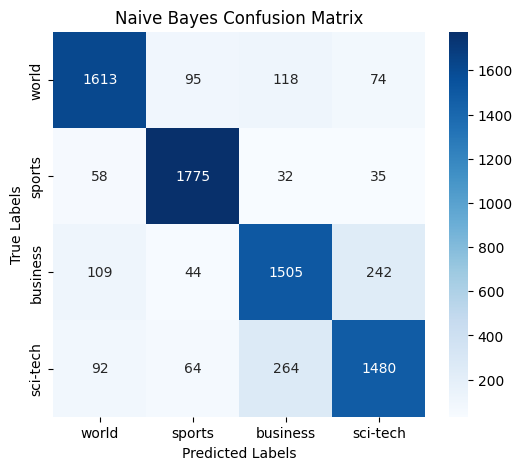

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

clf = make_pipeline(
    CountVectorizer(), # vectorize the speeches
    MultinomialNB() # fit Naive Bayes model
)

clf.fit(x_train, y_train)
y_pred_nb = clf.predict(x_test)
acc_nb= np.mean(y_test == y_pred_nb)
print(f"Accuracy (test data) = {acc_nb:.4f}")

print("Classification report:\n", classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=[0,1,2,3])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

## Logistic Regression Model

Accuracy (test data) = 0.8247
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1900
           1       0.86      0.93      0.89      1900
           2       0.80      0.76      0.78      1900
           3       0.78      0.78      0.78      1900

    accuracy                           0.82      7600
   macro avg       0.82      0.82      0.82      7600
weighted avg       0.82      0.82      0.82      7600



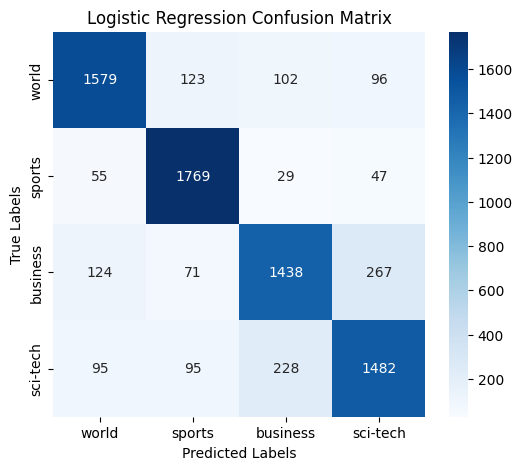

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

x_train, y_train = train_data['text'], train_data['labels']
x_test, y_test = test_data['text'], test_data['labels']

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

model_logistic = LogisticRegression() 
model_logistic.fit(x_train_tfidf, y_train)

y_pred_log = model_logistic.predict(x_test_tfidf)

acc_logistic = np.mean(y_test == y_pred_log)
print(f"Accuracy (test data) = {acc_logistic:.4f}")

print("Classification report:\n", classification_report(y_test, y_pred_log))

cm_logistic = confusion_matrix(y_test, y_pred_log, labels=[0,1,2,3])
cm_logistic
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# DistilBERT Model

In [9]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

import torch.nn.functional as F  # For softmax

In [10]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [11]:
# Adding tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True, padding = True)

max_token_length = train_data['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True))).max()
print("Maximum token length in the train data:", max_token_length)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Maximum token length in the train data: 199


In [12]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16

In [13]:
class MultiClassDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels # They are integers which are 0,1,2,3
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        target = self.targets[index]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [14]:
# Dataloader for the neural network

print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiClassDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiClassDataset(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (1000, 2)
TEST Dataset: (7600, 2)


In [15]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [16]:
# Necessary functions and DistilBERT class

class DistilBERTClass(torch.nn.Module):
    def __init__(self, hidden_size, dropout_rate):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, hidden_size) # This is about structure of the model
        self.dropout = torch.nn.Dropout(dropout_rate) # for regularization
        self.classifier = torch.nn.Linear(hidden_size, 4) # number of classes is 4

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

def train(model, epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()

def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            # Forward pass through the model and applying softmax
            outputs = model(ids, mask, token_type_ids)
            outputs_probs = F.softmax(outputs, dim=1)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs_probs.cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

Mounted at /content/drive

Testing combination: Hidden Size=256, Dropout=0.2, Epoch=3


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch: 0, Loss:  1.3314576148986816


63it [00:20,  3.14it/s]
1it [00:00,  4.76it/s]

Epoch: 1, Loss:  0.6093566417694092


63it [00:18,  3.40it/s]
1it [00:00,  4.29it/s]

Epoch: 2, Loss:  0.4359703063964844


63it [00:18,  3.33it/s]
475it [00:59,  8.03it/s]


Accuracy (test data) = 0.8840789473684211
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      1900
           1       0.96      0.98      0.97      1900
           2       0.83      0.85      0.84      1900
           3       0.82      0.87      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600



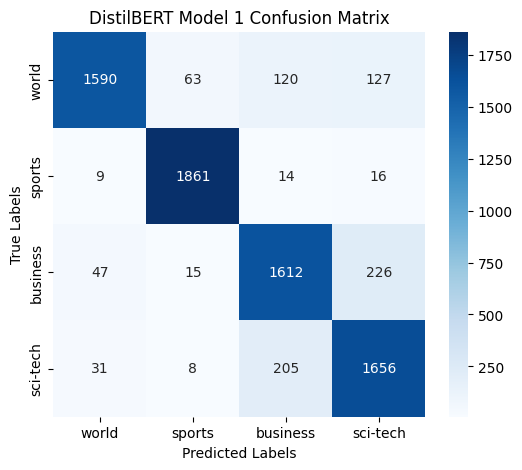

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_1.pth
Best model updated!

Testing combination: Hidden Size=256, Dropout=0.2, Epoch=5


1it [00:00,  4.91it/s]

Epoch: 0, Loss:  1.3753695487976074


63it [00:19,  3.19it/s]
1it [00:00,  4.01it/s]

Epoch: 1, Loss:  0.8169252872467041


63it [00:19,  3.18it/s]
1it [00:00,  4.08it/s]

Epoch: 2, Loss:  0.28270232677459717


63it [00:20,  3.15it/s]
1it [00:00,  3.97it/s]

Epoch: 3, Loss:  0.12178117036819458


63it [00:20,  3.15it/s]
1it [00:00,  3.90it/s]

Epoch: 4, Loss:  0.16868004202842712


63it [00:19,  3.16it/s]
475it [00:59,  8.02it/s]


Accuracy (test data) = 0.8910526315789473
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1900
           1       0.96      0.98      0.97      1900
           2       0.85      0.84      0.84      1900
           3       0.84      0.88      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



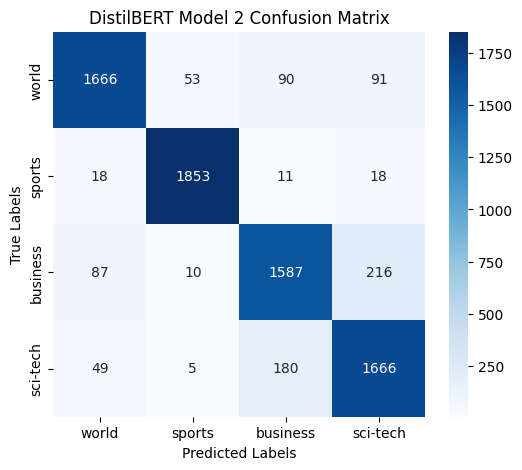

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_2.pth
Best model updated!

Testing combination: Hidden Size=256, Dropout=0.5, Epoch=3


1it [00:00,  4.57it/s]

Epoch: 0, Loss:  1.3928865194320679


63it [00:19,  3.15it/s]
1it [00:00,  3.86it/s]

Epoch: 1, Loss:  0.9252225160598755


63it [00:20,  3.14it/s]
1it [00:00,  3.92it/s]

Epoch: 2, Loss:  0.3972839117050171


63it [00:19,  3.15it/s]
475it [01:00,  7.87it/s]


Accuracy (test data) = 0.8868421052631579
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      1900
           1       0.96      0.98      0.97      1900
           2       0.82      0.86      0.84      1900
           3       0.84      0.86      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



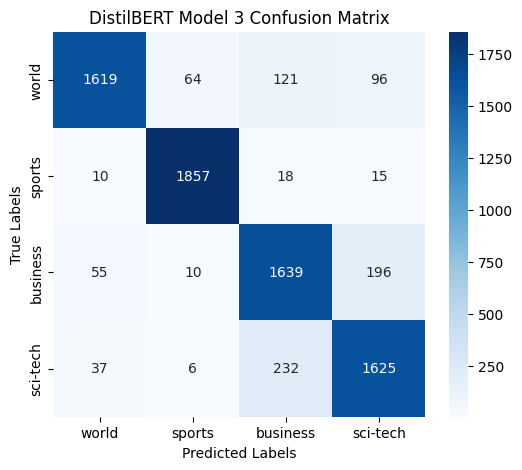

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_3.pth

Testing combination: Hidden Size=256, Dropout=0.5, Epoch=5


1it [00:00,  5.26it/s]

Epoch: 0, Loss:  1.500098705291748


63it [00:19,  3.16it/s]
1it [00:00,  3.92it/s]

Epoch: 1, Loss:  0.9573726654052734


63it [00:20,  3.14it/s]
1it [00:00,  4.04it/s]

Epoch: 2, Loss:  0.6397067904472351


63it [00:19,  3.16it/s]
1it [00:00,  3.93it/s]

Epoch: 3, Loss:  0.4826890230178833


63it [00:19,  3.17it/s]
1it [00:00,  3.98it/s]

Epoch: 4, Loss:  0.3728084862232208


63it [00:19,  3.16it/s]
475it [00:59,  7.98it/s]


Accuracy (test data) = 0.8868421052631579
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      1900
           1       0.96      0.97      0.96      1900
           2       0.82      0.85      0.84      1900
           3       0.85      0.85      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



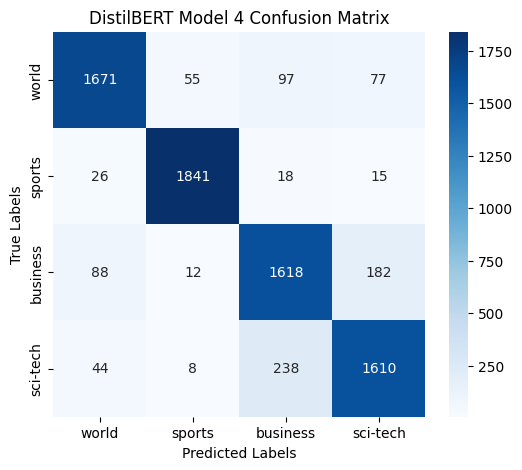

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_4.pth

Testing combination: Hidden Size=768, Dropout=0.2, Epoch=3


1it [00:00,  4.23it/s]

Epoch: 0, Loss:  1.3603103160858154


63it [00:19,  3.16it/s]
1it [00:00,  4.02it/s]

Epoch: 1, Loss:  0.6797440648078918


63it [00:20,  3.14it/s]
1it [00:00,  3.82it/s]

Epoch: 2, Loss:  0.18359152972698212


63it [00:20,  3.15it/s]
475it [00:59,  7.95it/s]


Accuracy (test data) = 0.8832894736842105
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89      1900
           1       0.95      0.98      0.97      1900
           2       0.91      0.75      0.82      1900
           3       0.77      0.94      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600



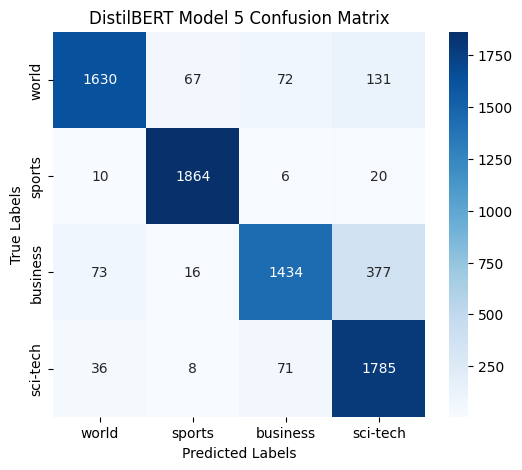

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_5.pth

Testing combination: Hidden Size=768, Dropout=0.2, Epoch=5


1it [00:00,  5.14it/s]

Epoch: 0, Loss:  1.3967238664627075


63it [00:19,  3.16it/s]
1it [00:00,  3.92it/s]

Epoch: 1, Loss:  0.7797532081604004


63it [00:20,  3.14it/s]
1it [00:00,  3.97it/s]

Epoch: 2, Loss:  0.36979490518569946


63it [00:19,  3.16it/s]
1it [00:00,  3.99it/s]

Epoch: 3, Loss:  0.2994396388530731


63it [00:19,  3.16it/s]
1it [00:00,  3.94it/s]

Epoch: 4, Loss:  0.06846116483211517


63it [00:19,  3.16it/s]
475it [01:00,  7.85it/s]


Accuracy (test data) = 0.8905263157894737
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1900
           1       0.96      0.97      0.97      1900
           2       0.88      0.80      0.84      1900
           3       0.83      0.90      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



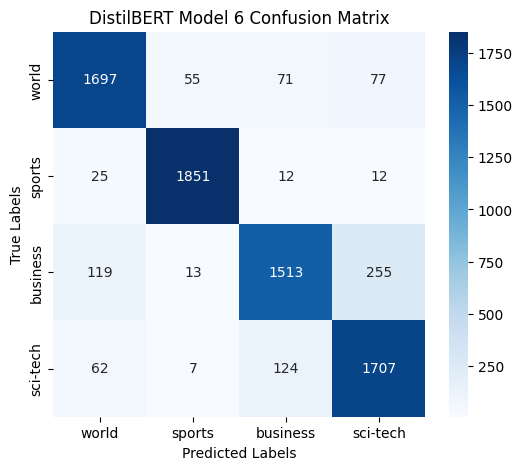

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_6.pth

Testing combination: Hidden Size=768, Dropout=0.5, Epoch=3


1it [00:00,  5.21it/s]

Epoch: 0, Loss:  1.4142738580703735


63it [00:19,  3.16it/s]
1it [00:00,  3.90it/s]

Epoch: 1, Loss:  0.9786978363990784


63it [00:20,  3.14it/s]
1it [00:00,  3.84it/s]

Epoch: 2, Loss:  0.38466209173202515


63it [00:20,  3.15it/s]
475it [00:59,  7.93it/s]


Accuracy (test data) = 0.8796052631578948
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      1900
           1       0.96      0.97      0.97      1900
           2       0.77      0.89      0.83      1900
           3       0.86      0.82      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600



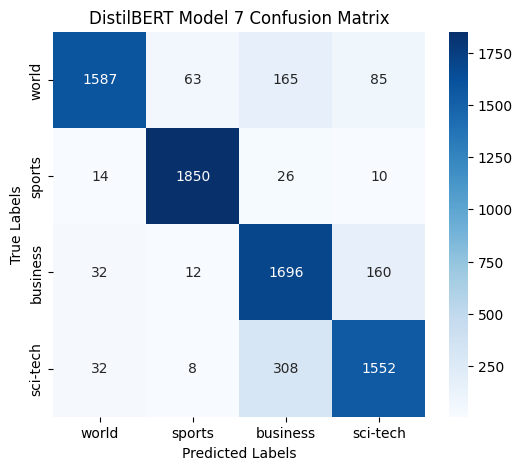

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_7.pth

Testing combination: Hidden Size=768, Dropout=0.5, Epoch=5


1it [00:00,  5.10it/s]

Epoch: 0, Loss:  1.4112592935562134


63it [00:19,  3.16it/s]
1it [00:00,  3.92it/s]

Epoch: 1, Loss:  0.8076242804527283


63it [00:20,  3.14it/s]
1it [00:00,  3.83it/s]

Epoch: 2, Loss:  0.6026883721351624


63it [00:19,  3.16it/s]
1it [00:00,  3.97it/s]

Epoch: 3, Loss:  0.13781538605690002


63it [00:19,  3.16it/s]
1it [00:00,  4.20it/s]

Epoch: 4, Loss:  0.27666884660720825


63it [00:19,  3.16it/s]
475it [01:00,  7.81it/s]


Accuracy (test data) = 0.8807894736842106
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.90      1900
           1       0.93      0.99      0.96      1900
           2       0.79      0.89      0.83      1900
           3       0.88      0.79      0.83      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



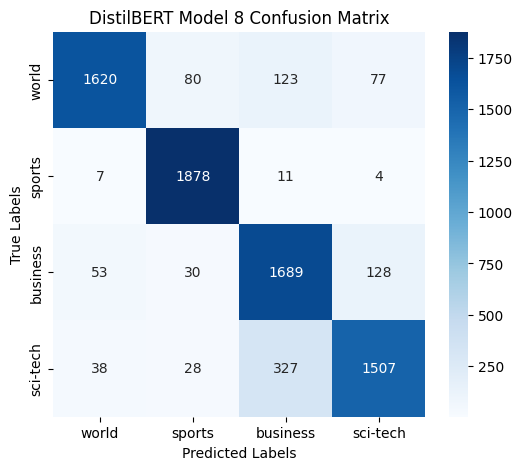

Model saved as /content/drive/MyDrive/DistilBERT_Models_1000/model_8.pth

Best Model: Hidden Size=256, Dropout=0.2, Epoch=5
Best Accuracy: 0.8911%


In [17]:
# Hyperparameter tuning

# Mount Google Drive do save the model parameters
from google.colab import drive
import os
drive.mount('/content/drive')

# Path to save models in Google Drive
save_dir = "/content/drive/MyDrive/DistilBERT_Models_1000"
os.makedirs(save_dir, exist_ok=True)

# Hyperparameter ranges
hidden_layer_sizes = [256, 768]
dropout_rates = [0.2, 0.5]
epoch_list = [3, 5]

# Generate all combinations
import itertools
all_combinations = list(itertools.product(hidden_layer_sizes, dropout_rates, epoch_list))

# Loss function for multiclass problem
loss_fn = torch.nn.CrossEntropyLoss()

# Save best model details
best_accuracy = 0.0
best_params = None

# Counter for saving models
model_counter = 1

# Training and validation loop
for hidden_size, dropout_rate, EPOCHS in all_combinations:
    print(f"\nTesting combination: Hidden Size={hidden_size}, Dropout={dropout_rate}, Epoch={EPOCHS}")

    model = DistilBERTClass(hidden_size, dropout_rate)
    model.to(device)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)  # Fixed learning rate

    # Training loop
    for epoch in range(EPOCHS):
      train(model, epoch)

    # Validation loop
    outputs, targets = validation(model, testing_loader) # Takes model as input

    # Calculate accuracy
    output_probs = np.array(outputs)
    final_outputs = np.argmax(output_probs, axis = 1)
    targets_labels = np.array(targets)
    accuracy = np.mean(targets_labels == final_outputs)
    print(f"Accuracy (test data) = {accuracy}")
    print("Classification report:\n", classification_report(targets_labels, final_outputs))

    cm_bert = confusion_matrix(targets_labels, final_outputs, labels=[0,1,2,3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"DistilBERT Model {model_counter} Confusion Matrix")
    plt.show()

    # Save the current model
    model_path = os.path.join(save_dir, f"model_{model_counter}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved as {model_path}")
    model_counter += 1

    # Update best model if needed
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (hidden_size, dropout_rate, EPOCHS)
        print("Best model updated!")

# Final output
print(f"\nBest Model: Hidden Size={best_params[0]}, Dropout={best_params[1]}, Epoch={best_params[2]}")
print(f"Best Accuracy: {best_accuracy:.4f}%")